In [ ]:
import pandas as pd
import numpy as np
import nflreadpy as nfl
from statsmodels.stats.proportion import proportions_ztest

try:
    print("Loading play-by-play data...")
    pbp_data = nfl.load_pbp(seasons=range(2002, 2025)).to_pandas()
    print(f"Loaded {len(pbp_data):,} play-by-play records")

    print("Loading schedules data...")
    schedules_data = nfl.load_schedules(seasons=range(2002, 2024)).to_pandas()
    print(f"Loaded {len(schedules_data):,} schedule records")

    print("Data loading complete!")

except Exception as e:
    print(f"Error loading data: {e}")

Loading play-by-play data...


Downloading: 100%|██████████| 14.8M/14.8M [00:09<00:00, 1.59MB/s]


Downloading: 100%|██████████| 14.6M/14.6M [00:08<00:00, 1.80MB/s]


Downloading: 100%|██████████| 14.6M/14.6M [00:13<00:00, 1.07MB/s]


Downloading: 100%|██████████| 14.6M/14.6M [00:13<00:00, 1.04MB/s]


Downloading: 100%|██████████| 18.6M/18.6M [00:15<00:00, 1.23MB/s]


Downloading: 100%|██████████| 18.7M/18.7M [00:11<00:00, 1.67MB/s]


Downloading: 100%|██████████| 18.6M/18.6M [00:10<00:00, 1.72MB/s]


Downloading: 100%|██████████| 18.9M/18.9M [00:17<00:00, 1.05MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:13<00:00, 1.42MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:11<00:00, 1.72MB/s]


Downloading: 100%|██████████| 19.3M/19.3M [00:05<00:00, 3.57MB/s]


Downloading: 100%|██████████| 19.5M/19.5M [00:08<00:00, 2.29MB/s]


Downloading: 100%|██████████| 19.4M/19.4M [00:06<00:00, 2.91MB/s]


Downloading: 100%|██████████| 19.5M/19.5M [00:09<00:00, 2.04MB/s]


Downloading: 100%|██████████| 19.3M/19.3M [00:06<00:00, 2.82MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:09<00:00, 2.07MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:05<00:00, 3.45MB/s]


Downloading: 100%|██████████| 19.1M/19.1M [00:07<00:00, 2.73MB/s]


Downloading: 100%|██████████| 19.3M/19.3M [00:12<00:00, 1.50MB/s]


Downloading: 100%|██████████| 20.3M/20.3M [00:19<00:00, 1.05MB/s]


Downloading: 100%|██████████| 20.4M/20.4M [00:10<00:00, 1.91MB/s]


Downloading: 100%|██████████| 20.5M/20.5M [00:34<00:00, 600kB/s] 


Downloading: 100%|██████████| 20.6M/20.6M [00:22<00:00, 912kB/s] 


Loaded 1,094,261 play-by-play records
Loading schedules data...


Downloading: 2.10MB [00:00, 3.64MB/s]                          

Loaded 5,929 schedule records
Data loading complete!


In [ ]:

print("Filtering play-by-play data to regular season games...")
# Filter to regular season games only
pbp_reg = pbp_data[pbp_data['season_type'] == 'REG'].copy()
# Remove rows with null or invalid game_id
pbp_reg = pbp_reg.dropna(subset=['game_id'])
print(f"After filtering: {len(pbp_reg):,} regular season play records")

# Filter schedules to regular season games only
schedules_reg = schedules_data[schedules_data['game_type'] == 'REG'].copy()
print(f"Regular season games before cleaning: {len(schedules_reg):,}")

# Remove any rows with null scores first
schedules_reg = schedules_reg.dropna(subset=['home_score', 'away_score'])
print(f"After removing null scores: {len(schedules_reg):,}")

# Remove tie games (where home_score == away_score)
# Ties don't fit binary win/loss classification
ties_removed = schedules_reg[schedules_reg['home_score'] == schedules_reg['away_score']]
print(f"Tie games found and removed: {len(ties_removed)}")

schedules_reg = schedules_reg[schedules_reg['home_score'] != schedules_reg['away_score']].copy()
print(f"Final regular season games (no ties): {len(schedules_reg):,}")

print("Data filtering complete!")

Filtering play-by-play data to regular season games...
After filtering: 1,047,916 regular season play records
Regular season games before cleaning: 5,679
After removing null scores: 5,679
Tie games found and removed: 14
Final regular season games (no ties): 5,665
Data filtering complete!


In [ ]:


# Single aggregation for all offensive stats by game and team
offensive_features = pbp_reg.groupby(['game_id', 'posteam']).agg({
    # First downs - any play that resulted in a first down
    'first_down': lambda x: (x == 1).sum(),
    # Passing yards - sum all passing yards (includes negative sack yards)
    'passing_yards': lambda x: x.fillna(0).sum(),
    # Rushing yards - sum all rushing yards
    'rushing_yards': lambda x: x.fillna(0).sum(),
    # Turnovers lost
    'fumble_lost': lambda x: (x == 1).sum(),
    'interception': lambda x: (x == 1).sum()
}).reset_index()

offensive_features['off_1st_down'] = offensive_features['first_down']
offensive_features['off_pass_yds'] = offensive_features['passing_yards']
offensive_features['off_rush_yds'] = offensive_features['rushing_yards']
offensive_features['off_turnovers'] = offensive_features['fumble_lost'] + offensive_features['interception']
offensive_features['off_total_yds'] = offensive_features['off_pass_yds'] + offensive_features['off_rush_yds']

# Keep only the final columns we need
offensive_features = offensive_features[['game_id', 'posteam', 'off_1st_down', 'off_pass_yds',
                                       'off_rush_yds', 'off_total_yds', 'off_turnovers']]

# Fill any remaining NaN values with 0
offensive_features = offensive_features.fillna(0)

print(f"Offensive features calculated for {len(offensive_features):,} team-game combinations")
print(offensive_features.head())

Offensive features calculated for 11,902 team-game combinations
           game_id posteam  off_1st_down  off_pass_yds  off_rush_yds  \
0  2002_01_ARI_WAS     ARI            14         187.0          70.0   
1  2002_01_ARI_WAS     WAS            21         327.0         122.0   
2   2002_01_ATL_GB     ATL            22         209.0         180.0   
3   2002_01_ATL_GB      GB            29         284.0         211.0   
4  2002_01_BAL_CAR     BAL            15         218.0          77.0   

   off_total_yds  off_turnovers  
0          257.0              1  
1          449.0              1  
2          389.0              1  
3          495.0              1  
4          295.0              1  


In [ ]:


team_mapping = {
    'SD': 'LAC',   # Los Angeles Chargers : San Diego Chargers
    'OAK': 'LV',   # Las Vegas Raiders : Oakland Raiders
    'STL': 'LA'    # Los Angeles Rams : St. Louis Rams
}

offensive_features['posteam'] = offensive_features['posteam'].replace(team_mapping)
print(f"Mapping applied to {len(offensive_features):,} offensive feature records")

schedules_reg['home_team'] = schedules_reg['home_team'].replace(team_mapping)
schedules_reg['away_team'] = schedules_reg['away_team'].replace(team_mapping)
print(f"Mapping applied to schedules: {schedules_reg['home_team'].nunique()} unique teams")

all_offensive_teams = set(offensive_features['posteam'].unique())
all_schedule_teams = set(schedules_reg['home_team'].unique()) | set(schedules_reg['away_team'].unique())
print(f"\nVerification:")
print(f"  Teams in offensive features: {len(all_offensive_teams)}")
print(f"  Teams in schedules: {len(all_schedule_teams)}")


Mapping applied to 11,902 offensive feature records
Mapping applied to schedules: 32 unique teams

Verification:
  Teams in offensive features: 32
  Teams in schedules: 32


In [ ]:

# Create a copy of offensive features to transform into defensive features
defensive_features = offensive_features.copy()


home_mapping = schedules_reg[['game_id', 'home_team', 'away_team']].rename(columns={
    'home_team': 'posteam', 'away_team': 'opponent'
})
away_mapping = schedules_reg[['game_id', 'away_team', 'home_team']].rename(columns={
    'away_team': 'posteam', 'home_team': 'opponent'
})

team_opponent_mapping = pd.concat([home_mapping, away_mapping], ignore_index=True)

offensive_with_opponents = offensive_features.merge(
    team_opponent_mapping,
    on=['game_id', 'posteam'],
    how='left'
)

# Create defensive features: Team A's defensive stats = Team B's offensive stats

defensive_features = offensive_with_opponents.copy()
defensive_features['team'] = defensive_features['opponent']  # The team we're calculating defense for
defensive_features = defensive_features.drop(['posteam', 'opponent'], axis=1)
defensive_features = defensive_features.rename(columns={'team': 'posteam'})

defensive_features = defensive_features.rename(columns={
    'off_1st_down': 'def_1st_down',
    'off_pass_yds': 'def_pass_yds',
    'off_rush_yds': 'def_rush_yds',
    'off_total_yds': 'def_total_yds',
    'off_turnovers': 'def_turnovers'
})

defensive_features.head()

game_id  def_1st_down  def_pass_yds  def_rush_yds  def_total_yds  \
0  2002_01_ARI_WAS            14         187.0          70.0          257.0   
1  2002_01_ARI_WAS            21         327.0         122.0          449.0   
2   2002_01_ATL_GB            22         209.0         180.0          389.0   
3   2002_01_ATL_GB            29         284.0         211.0          495.0   
4  2002_01_BAL_CAR            15         218.0          77.0          295.0   

   def_turnovers posteam  
0              1     WAS  
1              1     ARI  
2              1      GB  
3              1     ATL  
4              1     CAR

In [ ]:

print("Merging offensive and defensive features...")


combined_features = offensive_features.merge(
    defensive_features[['game_id', 'posteam', 'def_1st_down',
                       'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers']],
    on=['game_id', 'posteam'],
    how='left'
)

print(f"Combined features dataset: {len(combined_features):,} team-game combinations")
combined_features.head()

Merging offensive and defensive features...
Combined features dataset: 11,902 team-game combinations


game_id posteam  off_1st_down  off_pass_yds  off_rush_yds  \
0  2002_01_ARI_WAS     ARI            14         187.0          70.0   
1  2002_01_ARI_WAS     WAS            21         327.0         122.0   
2   2002_01_ATL_GB     ATL            22         209.0         180.0   
3   2002_01_ATL_GB      GB            29         284.0         211.0   
4  2002_01_BAL_CAR     BAL            15         218.0          77.0   

   off_total_yds  off_turnovers  def_1st_down  def_pass_yds  def_rush_yds  \
0          257.0              1          21.0         327.0         122.0   
1          449.0              1          14.0         187.0          70.0   
2          389.0              1          29.0         284.0         211.0   
3          495.0              1          22.0         209.0         180.0   
4          295.0              1          15.0         136.0         145.0   

   def_total_yds  def_turnovers  
0          449.0            1.0  
1          257.0            1.0  
2          495.0            1.0  
3          389.0            1.0  
4          281.0            0.0

In [ ]:

# Create separate dataframes for home and away teams with their scores
home_teams = schedules_reg[['game_id', 'season', 'week', 'gameday',
'home_team', 'home_score', 'away_score', 'overtime']].rename(columns={
    'home_team': 'posteam',
    'home_score': 'tm_score',
    'away_score': 'opp_score',
    'overtime': 'overtime'
})
home_teams['home'] = 1

away_teams = schedules_reg[['game_id', 'season', 'week', 'gameday',
'away_team', 'away_score', 'home_score', 'overtime']].rename(columns={
    'away_team': 'posteam',
    'away_score': 'tm_score',
    'home_score': 'opp_score',
    'overtime': 'overtime'
})
away_teams['home'] = 0

# Combine home and away team data
game_context = pd.concat([home_teams, away_teams], ignore_index=True)

# Merge combined features with game context
final_features = combined_features.merge(
    game_context,
    on=['game_id', 'posteam'],
    how='left'
)

missing_context_after = final_features['season'].isnull().sum()
print(f"Records still missing context: {missing_context_after}")

final_features.head()

Records still missing context: 572


game_id posteam  off_1st_down  off_pass_yds  off_rush_yds  \
0  2002_01_ARI_WAS     ARI            14         187.0          70.0   
1  2002_01_ARI_WAS     WAS            21         327.0         122.0   
2   2002_01_ATL_GB     ATL            22         209.0         180.0   
3   2002_01_ATL_GB      GB            29         284.0         211.0   
4  2002_01_BAL_CAR     BAL            15         218.0          77.0   

   off_total_yds  off_turnovers  def_1st_down  def_pass_yds  def_rush_yds  \
0          257.0              1          21.0         327.0         122.0   
1          449.0              1          14.0         187.0          70.0   
2          389.0              1          29.0         284.0         211.0   
3          495.0              1          22.0         209.0         180.0   
4          295.0              1          15.0         136.0         145.0   

   def_total_yds  def_turnovers  season  week     gameday  tm_score  \
0          449.0            1.0  2002.0   1.0  2002-09-08      23.0   
1          257.0            1.0  2002.0   1.0  2002-09-08      31.0   
2          495.0            1.0  2002.0   1.0  2002-09-08      34.0   
3          389.0            1.0  2002.0   1.0  2002-09-08      37.0   
4          281.0            0.0  2002.0   1.0  2002-09-08       7.0   

   opp_score  overtime  home  
0       31.0       0.0   0.0  
1       23.0       0.0   1.0  
2       37.0       1.0   0.0  
3       34.0       1.0   1.0  
4       10.0       0.0   0.0

In [ ]:

# Remove records with missing context data first (these can't have wins/losses calculated)
clean_features = final_features.dropna(subset=['season', 'week', 'tm_score', 'opp_score']).copy()
print(f"Removed records with missing context, {len(clean_features):,} records remaining")

# Remove any invalid team entries
clean_features = clean_features[clean_features['posteam'] != 0].copy()
print(f"Removed invalid team entries, {len(clean_features):,} records remaining")

# Create win indicator
clean_features['won'] = (clean_features['tm_score'] > clean_features['opp_score']).astype(int)

clean_features['wins'] = 0
clean_features['losses'] = 0

# Calculate running wins and losses for each team in each season
for team in clean_features['posteam'].unique():
    if pd.isna(team):  # Skip any NaN teams
        continue
    for season in clean_features['season'].unique():
        if pd.isna(season):  # Skip any NaN seasons
            continue
        mask = (clean_features['posteam'] == team) & (clean_features['season'] == season)
        team_season_games = clean_features[mask].copy()

        if len(team_season_games) > 0:
            team_season_games = team_season_games.sort_values(['week', 'gameday', 'game_id'])

            wins_so_far = team_season_games['won'].shift(1).fillna(0).cumsum()
            losses_so_far = (1 - team_season_games['won']).shift(1).fillna(0).cumsum()

            clean_features.loc[team_season_games.index, 'wins'] = wins_so_far.astype(int)
            clean_features.loc[team_season_games.index, 'losses'] = losses_so_far.astype(int)


clean_features[['posteam', 'season', 'week', 'tm_score', 'opp_score', 'won', 'wins', 'losses', 'overtime']].head(10)

Removed records with missing context, 11,330 records remaining
Removed invalid team entries, 11,330 records remaining


posteam  season  week  tm_score  opp_score  won  wins  losses  overtime
0     ARI  2002.0   1.0      23.0       31.0    0     0       0       0.0
1     WAS  2002.0   1.0      31.0       23.0    1     0       0       0.0
2     ATL  2002.0   1.0      34.0       37.0    0     0       0       1.0
3      GB  2002.0   1.0      37.0       34.0    1     0       0       1.0
4     BAL  2002.0   1.0       7.0       10.0    0     0       0       0.0
5     CAR  2002.0   1.0      10.0        7.0    1     0       0       0.0
6     DAL  2002.0   1.0      10.0       19.0    0     0       0       0.0
7     HOU  2002.0   1.0      19.0       10.0    1     0       0       0.0
8     DET  2002.0   1.0      21.0       49.0    0     0       0       0.0
9     MIA  2002.0   1.0      49.0       21.0    1     0       0       0.0

In [ ]:


clean_features['outcome'] = clean_features['won']



all_columns = [
    'game_id', 'posteam', 'season', 'week', 'overtime',
    'off_1st_down', 'off_pass_yds', 'off_rush_yds', 'off_total_yds', 'off_turnovers',
    'def_1st_down', 'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers',
    'tm_score', 'opp_score', 'home', 'wins', 'losses', 'outcome'
]


# Select only the features we need for modeling
model_features = clean_features[all_columns].copy()


model_features.head()

game_id posteam  season  week  overtime  off_1st_down  \
0  2002_01_ARI_WAS     ARI  2002.0   1.0       0.0            14   
1  2002_01_ARI_WAS     WAS  2002.0   1.0       0.0            21   
2   2002_01_ATL_GB     ATL  2002.0   1.0       1.0            22   
3   2002_01_ATL_GB      GB  2002.0   1.0       1.0            29   
4  2002_01_BAL_CAR     BAL  2002.0   1.0       0.0            15   

   off_pass_yds  off_rush_yds  off_total_yds  off_turnovers  ...  \
0         187.0          70.0          257.0              1  ...   
1         327.0         122.0          449.0              1  ...   
2         209.0         180.0          389.0              1  ...   
3         284.0         211.0          495.0              1  ...   
4         218.0          77.0          295.0              1  ...   

   def_pass_yds  def_rush_yds  def_total_yds  def_turnovers  tm_score  \
0         327.0         122.0          449.0            1.0      23.0   
1         187.0          70.0          257.0            1.0      31.0   
2         284.0         211.0          495.0            1.0      34.0   
3         209.0         180.0          389.0            1.0      37.0   
4         136.0         145.0          281.0            0.0       7.0   

   opp_score  home  wins  losses  outcome  
0       31.0   0.0     0       0        0  
1       23.0   1.0     0       0        1  
2       37.0   0.0     0       0        0  
3       34.0   1.0     0       0        1  
4       10.0   0.0     0       0        0  

[5 rows x 21 columns]

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


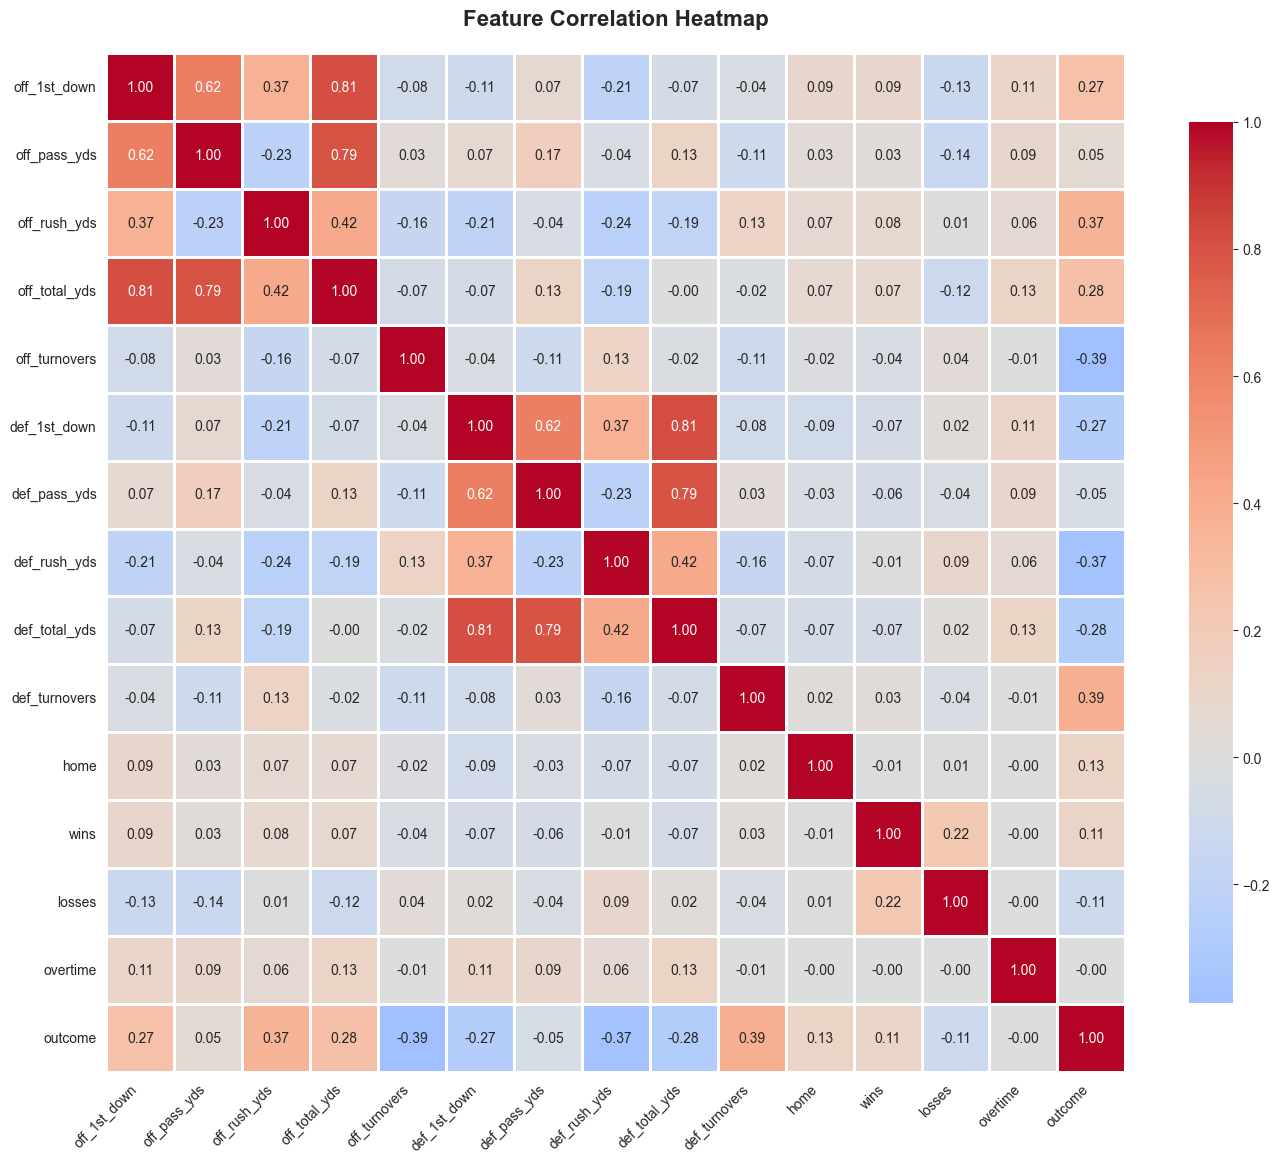


Strongest correlations with game outcome (win/loss):
def_turnovers    3.866663e-01
off_rush_yds     3.660353e-01
off_total_yds    2.759806e-01
off_1st_down     2.711325e-01
home             1.269197e-01
wins             1.116975e-01
off_pass_yds     4.865839e-02
overtime        -3.410252e-17
def_pass_yds    -4.865839e-02
losses          -1.120622e-01
def_1st_down    -2.711325e-01
def_total_yds   -2.759806e-01
def_rush_yds    -3.660353e-01
off_turnovers   -3.866663e-01
Name: outcome, dtype: float64


In [ ]:

numeric_features = ['off_1st_down', 'off_pass_yds', 'off_rush_yds', 'off_total_yds', 'off_turnovers',
                   'def_1st_down', 'def_pass_yds', 'def_rush_yds', 'def_total_yds', 'def_turnovers',
                   'home', 'wins', 'losses', 'overtime', 'outcome']

correlation_matrix = model_features[numeric_features].corr()

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nStrongest correlations with game outcome (win/loss):")
outcome_corr = correlation_matrix['outcome'].sort_values(ascending=False)
print(outcome_corr[outcome_corr.index != 'outcome'])

**Hypothesis Testing - Home Field Advantage during regular season, Statistical method ONE**


*Along with the questions above, here is the hypothesis testing

H0: The probability of the home team winning is equal to 50% (no home-field advantage)

Ha: The probability of the home team winning is greater than 50% (home-field advantage exists).

***Statistical test for result:***
The goal is to see how many games were won by the home team versus the away team to test whether or not there is a home-field advantage. We will use the Z-test because of the binary outcome (win or loss) and the sample size of data (around 272 games played in a regular season of the NFL)


We will be computing the z-test for each season and for all regular season games in the past five years in order to see the general effect and variability over time

In [ ]:
z_seasons = [2020, 2021, 2022, 2023, 2024]
z_schedules = nfl.load_schedules(z_seasons)

games_df = z_schedules.to_pandas()

# Filter to reg szn only
completed_games = games_df[games_df['game_type'] == 'REG'].copy()
completed_games = completed_games[~completed_games['home_score'].isna()].copy()

if len(completed_games) > 0:
    # Calculate basic home field advantage
    completed_games['home_win'] = (completed_games['home_score'] > completed_games['away_score']).astype(int)

    home_win_rate = completed_games['home_win'].mean()
    print(f"Home teams win {home_win_rate:.1%} of games")

    # By season
    print(f"\nHome win rate by season:")
    season_home_wins = completed_games.groupby('season')['home_win'].mean()

    for season, win_rate in season_home_wins.items():
        print(f"  {season}: {win_rate:.1%}")


    # Calculate point differentials
    completed_games['point_diff'] = completed_games['home_score'] - completed_games['away_score']
    avg_home_advantage = completed_games['point_diff'].mean()
    print(f"\nAverage home field advantage: {avg_home_advantage:.1f} points")


    #Z-Test by Season
    # to keep track of data for table:
    season_res_chart = []
    #group by season with the total of home wins and total games for the season
    season_count = completed_games.groupby('season').agg(
        season_home_wins =('home_win', 'sum'),
        season_total_games = ('home_win', 'count')
    ).reset_index()
    #excluding 2020 season as a factor, COVID games had no fans
    season_count = season_count[season_count['season'] != 2020]
    print(f"\n Total games and wins by season:\n {season_count}")
    for row in season_count.itertuples():
      nobs=row[3]
      count=row[2]
      season=row[1]
      z_stat, p_value = proportions_ztest(count=count, nobs=nobs, value=0.5, alternative='larger')
      print(f"\nSeason {season}: 'z_score': {z_stat:.4f}, 'p_value': {p_value:.4f}")
      season_res_chart.append({'Season': str(season),
        'Observed Win Rate': count / nobs,
        'P-Value (one-sided)': p_value,
        'Home Wins': count,
        'Total Games': nobs})

      alpha = 0.05
      if p_value <= alpha:
        print("P-value is less than alpha,reject null hypothesis")
        print("The average home win rate is significantly greater than 50%.\n")
      else:
        print("P-value is greater than alpha, fail to reject null hypothesis")
        print("There is not enough evidence to conclude that the average home win rate is greater than 50%.\n")


    ##plot for first Z-test
    seasonal_df = pd.DataFrame(season_res_chart)
    plt.figure(figsize=(7, 4))
    bars = plt.bar(seasonal_df['Season'], seasonal_df['P-Value (one-sided)'])
    plt.axhline(0.05, color='red', linestyle='--', linewidth=1, label='Significance level (alpha = 0.05)')

    for bar in bars:
        bar.set_color('forestgreen')

    plt.title('Home Win Rate by Season (Excluding 2020)')
    plt.ylabel('P-Value')
    plt.xlabel('Season')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


    # Z-test Statistic for all regular season games:
    print("Z-Test for all regular season games in the completed_games dataset (excluding 2020):")
    updated_completed_games = completed_games[completed_games['season'] != 2020]
    total_home_wins= updated_completed_games['home_win'].sum().astype(int)
    n_games = updated_completed_games['home_win'].count().astype(int)
    z_stat, p_value = proportions_ztest(count=total_home_wins, nobs=n_games, value=0.5, alternative='larger')
    print(f"\nZ-statistic: {z_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    alpha = 0.05
    if p_value <= alpha:
      print("Conclusion: P-value less than alpha value, Reject the null hypothesis.")
      print("\nThe average home win rate is significantly greater than 50%.")
    else:
      print("Conclusion: P-value greater than alpha value, Fail to reject the null hypothesis.")
      print("\nThere is not enough evidence to conclude that the average home win rate is greater than 50%.")

    #Graph for second z-test for all season games (combined seasons)
    plt.figure(figsize=(5, 5))
    # Plot single bar to represent the p-value
    plt.bar(['Overall P-Value'], [p_value],
        color='forestgreen' ,
        width=0.5)

    #line for alpha
    plt.axhline(alpha, color='red', linestyle='--', linewidth=1, label=r'Significance Level - alpha)')

    plt.title(f'Overall Z-Test P-Value vs. alpha ({n_games} Games)')
    plt.ylabel('P-Value')
    plt.ylim(0, 0.1)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No completed games found in dataset")

**Z-Test results/Conclusions**
1. Z-Test by Season

The 2021 and 2024 season both fail to reject the null hypothesis, and
the 2022 and 2023 season reject the null hypothesis.

The difference in these results suggest that home-field advantage may vary from year to year, because of its sensitivity to external factors (like COVID)

2. Z-Test, combining multiple seasons

Despite the fluctuations in the individual seasons, the combined data supports that nfl home teams won more than 50% of their games, indicating a robust overall home-field advantage.



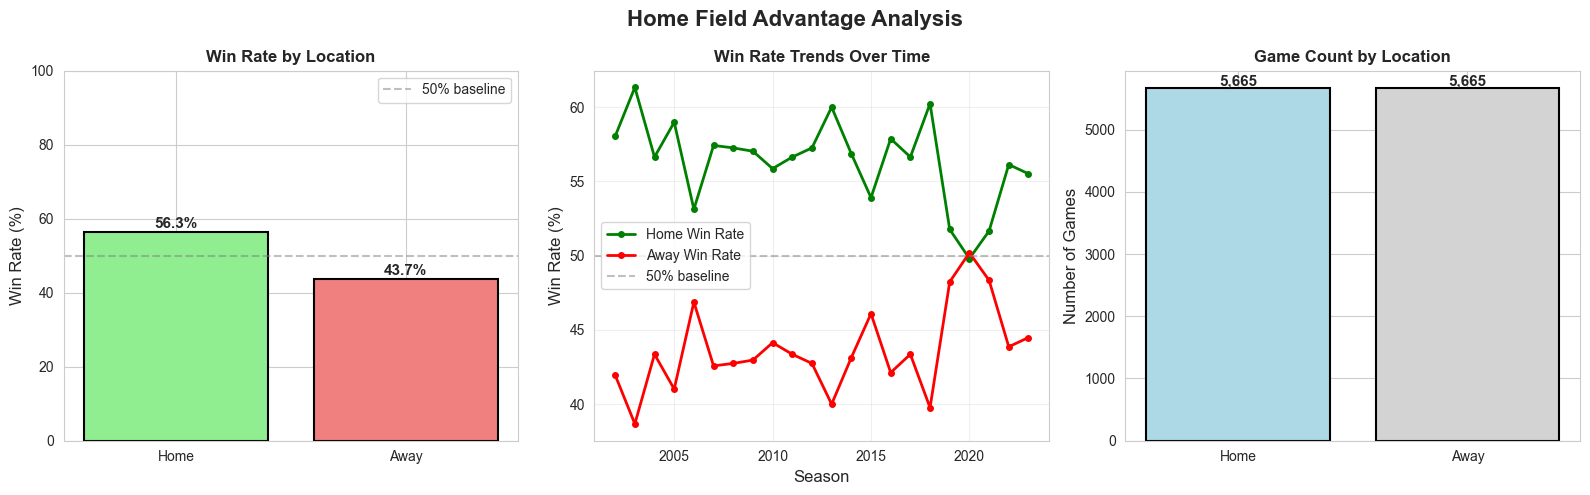


=== Home Field Advantage Statistics ===
Home Win Rate: 56.35% (3,192 wins out of 5,665 games)
Away Win Rate: 43.65% (2,473 wins out of 5,665 games)
Home Field Advantage: 12.69 percentage points


In [ ]:

home_games = model_features[model_features['home'] == 1]
away_games = model_features[model_features['home'] == 0]

home_win_rate = home_games['outcome'].mean()
away_win_rate = away_games['outcome'].mean()

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Home Field Advantage Analysis', fontsize=16, fontweight='bold')

# 1. Win rate comparison
ax1 = axes[0]
locations = ['Home', 'Away']
win_rates = [home_win_rate * 100, away_win_rate * 100]
colors = ['lightgreen', 'lightcoral']
bars = ax1.bar(locations, win_rates, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Win Rate (%)', fontsize=12)
ax1.set_title('Win Rate by Location', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax1.legend()

# Add percentage labels on bars
for i, (bar, rate) in enumerate(zip(bars, win_rates)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

# 2. Win rate over seasons
ax2 = axes[1]
home_by_season = model_features[model_features['home'] == 1].groupby('season')['outcome'].mean() * 100
away_by_season = model_features[model_features['home'] == 0].groupby('season')['outcome'].mean() * 100

ax2.plot(home_by_season.index, home_by_season.values, 'o-', color='green',
         label='Home Win Rate', linewidth=2, markersize=4)
ax2.plot(away_by_season.index, away_by_season.values, 'o-', color='red',
         label='Away Win Rate', linewidth=2, markersize=4)
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax2.set_xlabel('Season', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_title('Win Rate Trends Over Time', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Count of games
ax3 = axes[2]
game_counts = [len(home_games), len(away_games)]
bars = ax3.bar(locations, game_counts, color=['lightblue', 'lightgray'],
               edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Number of Games', fontsize=12)
ax3.set_title('Game Count by Location', fontsize=12, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, game_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== Home Field Advantage Statistics ===")
print(f"Home Win Rate: {home_win_rate*100:.2f}% ({home_games['outcome'].sum():,} wins out of {len(home_games):,} games)")
print(f"Away Win Rate: {away_win_rate*100:.2f}% ({away_games['outcome'].sum():,} wins out of {len(away_games):,} games)")
print(f"Home Field Advantage: {(home_win_rate - away_win_rate)*100:.2f} percentage points")

# Dataset Analysis Conclusion

## Dataset Overview

This NFL game outcome dataset contains 11,330 team-game records spanning from the 2002 to 2024 regular seasons
The dataset contains 21 features organized into four main categories: identifiers
(game_id, posteam, season, week), offensive statistics (5 features), defensive statistics (5 features), game context (4 features), and the target variable (outcome). After cleaning, the dataset represents 5,665 complete games with 32 unique NFL teams, maintaining a  balanced structure where each game generates two records.

## Feature Characteristics and Distribution

The dataset exhibits good balance with exactly 50% wins and 50% losses across all records, as expected from the paired nature of game outcomes. However, a signifiant home field advantage is evident in the data: home teams win 56.35% of games (3,192 wins) compared to away teams' 43.65% (2,473 wins), representing a substantial 12.69 percentage point advantage. This home field advantage has remained relatively consistent across all 23 seasons analyzed, showing minimal variance over time, which suggests it is a stable and persistent factor in NFL outcomes.

## Feature Correlations and Predictive Importance

The correlation analysis reveals several insights about feature relationships and their ability to predict game outcomes:

**Strongest Positive Predictors:**
- Defensive turnovers forced (0.387)
- Offensive rushing yards (0.366)
- Offensive total yards (0.276)
- Offensive first downs (0.271)
- Home field advantage (0.127)

**Strongest Negative Predictors:**
- Offensive turnovers committed (-0.387)
- Defensive rushing yards allowed (-0.366)
- Defensive total yards allowed (-0.276)
- Defensive first downs allowed (-0.271)
